# SIR модель #
Работа выполнена студентом группы 23КНТ2 ИМИКН ВШЭ НН ***Власовым Артёмом Дмитриевичем***

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_excel('Великобритания.xlsx', sheet_name='Sheet1')
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0.0,10,63181775,8256935,121693
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1.0,25,63181775,8388397,131462
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2.0,17,63181775,8522679,134282
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9.0,9,63181775,8663993,141314
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0.0,32,63181775,8798036,134043


In [27]:
df.tail()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
604,Великобритания,16.03.2022,20059641,NaN,163833,93943,NaN,153,63181775,476632060,853716
605,Великобритания,17.03.2022,20150847,NaN,163972,91206,NaN,139,63181775,477378853,746793
606,Великобритания,18.03.2022,20243940,NaN,164099,93093,NaN,127,63181775,477950504,571651
607,Великобритания,19.03.2022,20243940,NaN,164099,0,NaN,0,63181775,478578610,628106
608,Великобритания,20.03.2022,20243940,NaN,164099,0,NaN,0,63181775,0,0


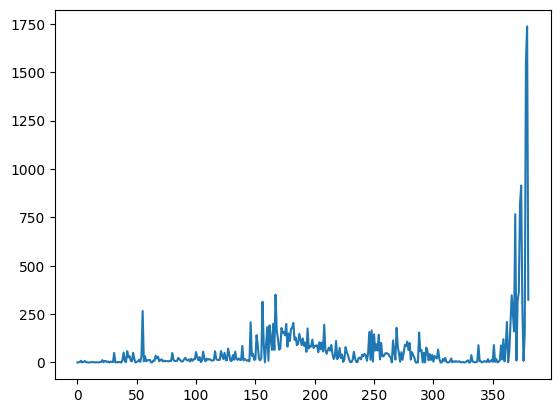

In [28]:
plt.plot(df.index, df['Выздоровлений за день'])
plt.show()

Смотрим, в какие столбцах есть пропуски

In [29]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Страна                 609 non-null    object 
 1   Дата                   609 non-null    object 
 2   Заражений              609 non-null    int64  
 3   Выздоровлений          381 non-null    float64
 4   Смертей                609 non-null    int64  
 5   Заражений за день      609 non-null    int64  
 6   Выздоровлений за день  381 non-null    float64
 7   Смертей за день        609 non-null    int64  
 8   Население страны       609 non-null    int64  
 9   Тестов                 609 non-null    int64  
 10  Тестов за день         609 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 52.5+ KB
None


# Работает с пропущенными значениями c использованием алгоритмов машинного обучения

Как мы видим, начиная с 381 строки в столбцах **'Выздоровлений за день'** и **'Выздоровлений'** вместо данных идут пропуски. Используем Random Forest Regressor, чтобы обучить на первых 300+ строках, а затем предсказать недостающие значения.

Перейдём к следующим шагам:

1. Построим модель случайного леса по непустым данным.

2. Применим её к строкам с пропущенными значениями.

3. Заполним пропуски предсказаниями модели.

In [30]:
from sklearn.ensemble import RandomForestRegressor

def fill_daily_recovered(df):
    """
    Заполнение ежедневных выздоровлений через регрессию
    """

    df['Индекс_дня'] = df.index

    known = df[df['Выздоровлений за день'].notna()]

    X = known[['Индекс_дня', 'Тестов за день']].values
    y = known['Выздоровлений за день'].values

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    all_X = df[['Индекс_дня', 'Тестов за день']].values
    predicted = model.predict(all_X)

    filled = df['Выздоровлений за день'].where(
        df['Выздоровлений за день'].notna(),
        np.round(predicted).clip(min=0)
    )
    return filled.astype(int)

Заполняем пропуски

In [31]:
df['Выздоровлений за день'] = fill_daily_recovered(df)

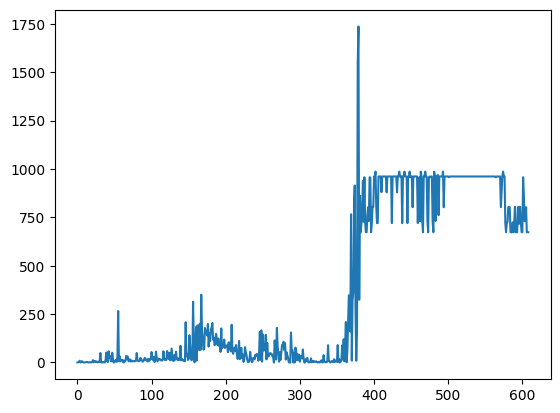

In [32]:
plt.plot(df.index, df['Выздоровлений за день'])
plt.show()

Вычисляем значения для столбца 'Выздоровлений' начиная с 381 строки, поскольку там тоже пропуски, но зная изначальное выздоровлений и все данные о выздоровлениях в день мы можем всё вычислить

In [33]:
start_index = 381

for i in range(start_index, len(df)):
    df.loc[i, 'Выздоровлений'] = df.loc[i-1, 'Выздоровлений'] + df.loc[i, 'Выздоровлений за день']

In [34]:
# Проверяем, нет ли пустых значений
df[df["Выздоровлений"].isnull()]

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день,Индекс_дня


Удаляем столбец **'Страна'**, **'Тестов'**, **'Тестов за день''**, **'Смертей за день'** и **'index'** поскольку они не несут никакой полезной информации для следующих заданий

In [35]:
df.drop(columns=['Страна'], inplace=True)
df.drop(columns=['Тестов'], inplace=True)
df.drop(columns=['Тестов за день'], inplace=True)
df.drop(columns=['Индекс_дня'], inplace=True)
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны
0,20.07.2020,296940,1413.0,41090,586,0,10,63181775
1,21.07.2020,297385,1414.0,41115,445,1,25,63181775
2,22.07.2020,297948,1416.0,41132,563,2,17,63181775
3,23.07.2020,298727,1425.0,41141,779,9,9,63181775
4,24.07.2020,299495,1425.0,41173,768,0,32,63181775


### 1. Вычислить количество инфицированных I на каждый день наблюдений

In [36]:
df['I'] = df['Заражений'] - df['Выздоровлений'] - df['Смертей']
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,I
0,20.07.2020,296940,1413.0,41090,586,0,10,63181775,254437.0
1,21.07.2020,297385,1414.0,41115,445,1,25,63181775,254856.0
2,22.07.2020,297948,1416.0,41132,563,2,17,63181775,255400.0
3,23.07.2020,298727,1425.0,41141,779,9,9,63181775,256161.0
4,24.07.2020,299495,1425.0,41173,768,0,32,63181775,256897.0


### 2. Выполнить нормировку данных на 100 тыс. населения

In [ ]:
population = df['Население страны'].iloc[0]

# Нормировка данных на 100k населения
df['I_norm'] = df['I'] / population * 100000
df['R'] = df['Выздоровлений'] + df['Смертей']
df['R_norm'] = df['R'] / population * 100000
df['S'] = df['Население страны'] - df['I'] - df['R']
df['S_norm'] = df['S'] / population * 100000

df['Заражений за день norm'] = df['Заражений за день'] / population * 100000
df['Выздоровлений за день norm'] = df['Выздоровлений за день'] / population * 100000
df['Смертей за день norm'] = df['Смертей за день'] / population * 100000 

In [38]:
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,I,I_norm,R,R_norm,S,S_norm,Заражений за день norm,Выздоровлений за день norm,Смертей за день norm
0,20.07.2020,296940,1413.0,41090,586,0,10,63181775,254437.0,402.706318,42503.0,67.270981,62884835.0,99530.022700,0.927483,0.000000,0.015827
1,21.07.2020,297385,1414.0,41115,445,1,25,63181775,254856.0,403.369484,42529.0,67.312132,62884390.0,99529.318383,0.704317,0.001583,0.039568
2,22.07.2020,297948,1416.0,41132,563,2,17,63181775,255400.0,404.230492,42548.0,67.342204,62883827.0,99528.427304,0.891080,0.003165,0.026906
3,23.07.2020,298727,1425.0,41141,779,9,9,63181775,256161.0,405.434953,42566.0,67.370694,62883048.0,99527.194353,1.232950,0.014245,0.014245
4,24.07.2020,299495,1425.0,41173,768,0,32,63181775,256897.0,406.599846,42598.0,67.421341,62882280.0,99525.978813,1.215540,0.000000,0.050648


### 3.На основе данных построить оценку параметра γ – интенсивности выздоровления

In [39]:
df['gamma'] = df['Выздоровлений за день'] / df['I'].shift(1)
gamma = df['gamma'].replace([np.inf, -np.inf], np.nan).mean()
print(f"\nОценка параметра γ: {gamma:.4f}")


Оценка параметра γ: 0.0001


### 4. С помощью метода наименьших квадратов построить оценку параметра SIR-модели β (интенсивность заражения) в предположении, что изначально все население является восприимчивым к заболеванию.

In [40]:
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,I,I_norm,R,R_norm,S,S_norm,Заражений за день norm,Выздоровлений за день norm,Смертей за день norm,gamma
0,20.07.2020,296940,1413.0,41090,586,0,10,63181775,254437.0,402.706318,42503.0,67.270981,62884835.0,99530.022700,0.927483,0.000000,0.015827,NaN
1,21.07.2020,297385,1414.0,41115,445,1,25,63181775,254856.0,403.369484,42529.0,67.312132,62884390.0,99529.318383,0.704317,0.001583,0.039568,0.000004
2,22.07.2020,297948,1416.0,41132,563,2,17,63181775,255400.0,404.230492,42548.0,67.342204,62883827.0,99528.427304,0.891080,0.003165,0.026906,0.000008
3,23.07.2020,298727,1425.0,41141,779,9,9,63181775,256161.0,405.434953,42566.0,67.370694,62883048.0,99527.194353,1.232950,0.014245,0.014245,0.000035
4,24.07.2020,299495,1425.0,41173,768,0,32,63181775,256897.0,406.599846,42598.0,67.421341,62882280.0,99525.978813,1.215540,0.000000,0.050648,0.000000


## Формула, из которой выражаем β

Из SIR-модели:

$
\frac{dI}{dt} = \beta \cdot \frac{S \cdot I}{N} - \gamma \cdot I
$

Преобразуем её:

$
\frac{dI}{dt} + \gamma \cdot I = \beta \cdot \frac{S \cdot I}{N}
$

---

## Данные

- `I` — количество инфицированных  
- `S` — количество восприимчивых  
- `γ` — уже оценили в предыдущем пункте 
- `dI/dt` — прирост инфицированных за день:  `Заражений за день - Выздоровлений за день - Смертей за день`

---

## Подстановка в форму линейной регрессии

Теперь у нас есть линейная зависимость:

$
y = \beta \cdot x
$

где:

- $ y = \frac{dI}{dt} + \gamma \cdot I $

- $ x = \frac{S \cdot I}{N} $

То есть:
- левая часть (`lhs`) — известна из данных  
- правая часть (`rhs`) — тоже известна  
- остаётся только оценить коэффициент **β**


In [41]:
N = 100000
df["S_norm_new"] = N - df['I_norm']

df['dI'] = df['Заражений за день norm'] - df['Выздоровлений за день norm'] - df['Смертей за день norm']
df['lhs'] = df['dI'] + gamma * df['I_norm']
df['rhs'] = df["S_norm_new"]  * df['I_norm'] / N

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(df['rhs']) 

# Оценка параметра β
# Используем метод наименьших квадратов
# Для этого создаем и используем объект модели OLS (Ordinary Least Squares) из  библиотеки statsmodels
# и передаем в него зависимую переменную (lhs) и независимую переменную (rhs)
# Затем вызываем метод fit() для оценки параметров модели
# После этого получаем параметры модели через атрибут params
model = sm.OLS(df['lhs'], X).fit()
beta = model.params[1]
print(f"\nОценка параметра β: {beta:.4f}")


Оценка параметра β: 0.0067


```model = sm.OLS(df['lhs'], X).fit()``` - Здесь используется метод наименьших квадратов, чтобы найти значение β, минимизирующее квадратичную ошибку между **lhs** и **β * rhs + const**

# 5. Построить график зависимости среднего количества инфицированных от времени. Для сравнения на той же диаграмме построить график для реальных (нормированных) данных

In [43]:
from scipy.integrate import odeint  # Импортируем odeint для интегрирования ОДУ

# Определяем модель SIR
N = df['Население страны'].iloc[0]
I0 = df['I'].iloc[0]
R0 = df['R'].iloc[0]
S0 = N - I0 - R0
y0 = [S0, I0, R0]

t = np.arange(len(df))  # временная ось в днях

In [44]:
# SIR уравнения
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [45]:
# Решение ОДУ
ret = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
I_model_norm = I / N * 100000

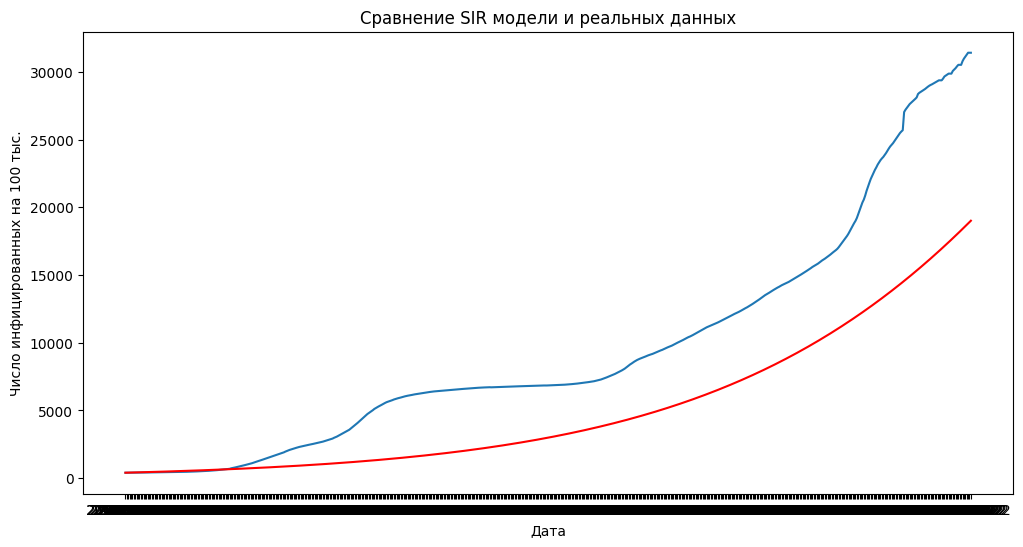

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df['Дата'], df['I_norm'], label='Реальные данные (нормированные)')
plt.plot(df['Дата'], I_model_norm, label='SIR модель (нормированные)', color = 'red')
plt.xlabel('Дата')
plt.ylabel('Число инфицированных на 100 тыс.')
plt.title('Сравнение SIR модели и реальных данных')
plt.show()